# Script de prueba para AXI Lite y AXI DMA

En este Notebook de python se prueba el funcionamient y se da un codigo minimo de interaccion con el AXI Lite a traves de `devmem` y con el AXI DMA usando librerias precompiladas de C `*.so`

--- 
### Carga de las librerias

Aqui se cargan las librerias necesarias, note que se usa `ctypes`, esta libreria es para cargar las librerias precompiladas de `C`, tambien la libreria `subprocess` que permite hacer escritura de comandos de bash en la terminal de petalinux

In [57]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import os
import time


import mmap
import struct
import subprocess

Aqui se definen las funciones para lectura y escritura del slowcontrol a traves de linux, esto usando `devmem`

In [58]:

def devmem(address: int, operation: str = "read", value: int = None, width: int = 32) -> int:
    """
    Lee o escribe en memoria física usando devmem.

    :param address: Dirección física (entero).
    :param operation: "read" para leer, "write" para escribir.
    :param value: Valor a escribir (solo si operation="write").
    :param width: Tamaño en bits (8, 16, 32 o 64).
    :return: Valor leído (si es operación de lectura).
    """
    addr_hex = hex(address)

    if operation == "read":
        result = subprocess.run(
            ["devmem", addr_hex, str(width)],
            capture_output=True,
            text=True,
            check=True
        )
        return int(result.stdout.strip(), 0)

    elif operation == "write":
        if value is None:
            raise ValueError("Se necesita un valor para escribir en memoria.")
        val_hex = hex(value)
        subprocess.run(
            ["devmem", addr_hex, str(width), val_hex],
            check=True
        )
        return value

    else:
        raise ValueError("Operación no válida. Use 'read' o 'write'.")

In [59]:
def run_command(command):
    """Ejecuta un comando en la terminal y muestra la salida en tiempo real."""
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    for line in process.stdout:
        print(line, end="")  # Imprime la salida en tiempo real

    process.wait()  # Esperar a que termine el proceso
    if process.returncode != 0:
        print(f"\nError en el comando: {command}")
        print(process.stderr.read())

---
### Carga del Overlay a traves de `xmutil`

Aqui se carga el overlay definido y mapeado con el device tree overlay

In [60]:
run_command("xmutil unloadapp")
run_command("xmutil loadapp axi_full_udea")

remove from slot 0 returns: -1 (Error)
axi_full_udea: loaded to slot 0


--- 
### Pruebas AXI Lite

Aqui se presentan algunas pruebas de escritura y lectura de los registros del Slow Control usando `devmem` para acceder al mapeo de memoria del AXI Lite IPCore

In [61]:
# Leer dirección 0x8001000C como entero de 32 bits
valor = devmem(0x80020004, "read", width=32)
print(f"Leído: {hex(valor)}")

Leído: 0x200


In [71]:
# Leer dirección 0x8001000C como entero de 32 bits
valor = devmem(0x80020008, "read", width=32)
print(f"Leído: {hex(valor)}")

Leído: 0x36


In [72]:
# Escribir el valor 0x2 en esa dirección
devmem(0x8002000C, "write", value=0x2, width=32)
print("Escritura realizada.")

Escritura realizada.


In [73]:
# Escribir el valor 0x2 en esa dirección
devmem(0x8002000C, "write", value=0x8, width=32)
print("Escritura realizada.")

# Escribir el valor 0x2 en esa dirección
devmem(0x80020010, "write", value=0xCE, width=32)
print("Escritura realizada.")

Escritura realizada.
Escritura realizada.


---

### Interaccion con DMA

A partir de aqui se hace interaccion con el DMA para lectura de datos, lo primero que se hace es que se carga la libreria precompilada de C, y luego que mapean las funciones para poder usarlas con los argumentos adecuados desde python

In [74]:
# Cargar la librería
lib = ctypes.CDLL("./DLL_library/libuio_dma.so")

In [75]:
# Prototipos
lib.dma_open_mem.restype = ctypes.c_void_p
lib.dma_open_mem.argtypes = [ctypes.c_long, ctypes.c_size_t, ctypes.c_long, ctypes.c_size_t]

lib.dma_start_and_wait.restype = ctypes.c_int
lib.dma_start_and_wait.argtypes = [ctypes.c_void_p, ctypes.c_uint32, ctypes.c_int]

lib.dma_read_reg.restype = ctypes.c_uint32
lib.dma_read_reg.argtypes = [ctypes.c_void_p, ctypes.c_uint32]

lib.dma_get_buffer_ptr.restype = ctypes.c_size_t
lib.dma_get_buffer_ptr.argtypes = [ctypes.c_void_p]

lib.dma_close.restype = None
lib.dma_close.argtypes = [ctypes.c_void_p]

Algo que se agrego fue la posibilidad de cambiar la señal a leer desde el axi dma, cuando se escribe en el registro `0x80020014`:
1. sale una senal seno 
2. sale una rampa 
3. sale un semicirculo

In [76]:
# Parámetros idénticos a tu script Python
DMA_REGS_PHY = 0x80010000
DMA_REGS_SIZE = 65536
DST_PHYS = 0x0d000000
DST_MAP_SIZE = 8192 * 4

In [83]:
# Escribir el valor 0x2 en esa dirección
devmem(0x80020014, "write", value=0x01, width=32)
print("Escritura realizada.")

# Leer dirección 0x8001000C como entero de 32 bits
valor = devmem(0x80020014, "read", width=32)
print(f"Leído: {hex(valor)}")

Escritura realizada.
Leído: 0x1


Opening handle via /dev/mem (C lib)...
Initial STATUS (from C lib) = 0x00005011
Starting DMA (C lib)...
DMA finished OK (C lib)
Tiempo total DMA (Python mmap): 6.177 ms
Tiempo total DMA (Python mmap): 0.116 ms
First 16 words: [  180   105    50    16 44228 43468 42702 41929 41151 40368 39581 38789
 37994 37195 36394 35590]


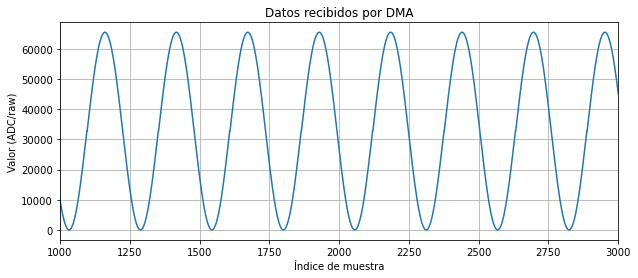

In [85]:
###################################################
t0 = time.perf_counter()

print("Opening handle via /dev/mem (C lib)...")
h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

# Leer status inicial (debug)
st = lib.dma_read_reg(h, 0x34)
print(f"Initial STATUS (from C lib) = 0x{st:08X}")

print("Starting DMA (C lib)...")
ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)
if ret == 0:
    print("DMA finished OK (C lib)")
elif ret == 1:
    print("DMA TIMEOUT (C lib)")
else:
    print("DMA ERROR (C lib)")
    
t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")


# Si terminó, leer buffer via pointer -> numpy
if ret == 0:
    ###################################################
    t0 = time.perf_counter()
    
    ptr = lib.dma_get_buffer_ptr(h)
    # create numpy array view: shape = DST_MAP_SIZE/4
    length_words = DST_MAP_SIZE // 4
    buffer_type = ctypes.c_uint32 * length_words
    buf = buffer_type.from_address(ptr)
    np_arr = np.ctypeslib.as_array(buf)
    
    t1 = time.perf_counter()
    ###################################################
    print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")
    
    print("First 16 words:", np_arr[:16])
    
    data = np.array(np_arr, dtype=np.uint16)

    # Crear eje x (muestras)
    x = np.arange(len(data))

    # Graficar
    plt.figure(figsize=(10,4))
    plt.plot(x, data)
    plt.title("Datos recibidos por DMA")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    # plt.show()
    plt.xlim([1000,3000])

lib.dma_close(h)

In [ ]:
###################################################
t0 = time.perf_counter()

h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

# Leer status inicial (debug)
st = lib.dma_read_reg(h, 0x34)
print(f"Initial STATUS (from C lib) = 0x{st:08X}")

print("Starting DMA (C lib)...")
ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)
if ret == 0:
    print("DMA finished OK (C lib)")
elif ret == 1:
    print("DMA TIMEOUT (C lib)")
else:
    print("DMA ERROR (C lib)")
    
t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")


# Si terminó, leer buffer via pointer -> numpy
if ret == 0:
    ###################################################
    t0 = time.perf_counter()
    
    ptr = lib.dma_get_buffer_ptr(h)
    # create numpy array view: shape = DST_MAP_SIZE/4
    length_words = DST_MAP_SIZE // 4
    buffer_type = ctypes.c_uint32 * length_words
    buf = buffer_type.from_address(ptr)
    np_arr = np.ctypeslib.as_array(buf)
    
    t1 = time.perf_counter()
    ###################################################
    print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")
    
    data = np.array(np_arr, dtype=np.uint16)

    # Crear eje x (muestras)
    x = np.arange(len(data))

    # Graficar
    plt.figure(figsize=(10,4))
    plt.plot(x, data)
    plt.title("Datos recibidos por DMA")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    # plt.show()
    plt.xlim([1000,3000])

lib.dma_close(h)

---
### Prueba de rendimiento

Finalmente se hace una prueba de rendimiento para evaluar los tiempos de configuracion y de lectura en la dma


Run 01: DMA = 0.361 ms, Read = 0.095 ms
Run 02: DMA = 1.076 ms, Read = 0.076 ms
Run 03: DMA = 0.546 ms, Read = 0.044 ms
Run 04: DMA = 0.452 ms, Read = 0.045 ms
Run 05: DMA = 0.518 ms, Read = 0.035 ms
Run 06: DMA = 0.516 ms, Read = 0.034 ms
Run 07: DMA = 0.533 ms, Read = 0.035 ms
Run 08: DMA = 0.560 ms, Read = 0.042 ms
Run 09: DMA = 0.532 ms, Read = 0.037 ms
Run 10: DMA = 0.532 ms, Read = 0.039 ms
Run 11: DMA = 0.541 ms, Read = 0.038 ms
Run 12: DMA = 0.084 ms, Read = 0.036 ms
Run 13: DMA = 0.525 ms, Read = 0.037 ms
Run 14: DMA = 0.548 ms, Read = 0.038 ms
Run 15: DMA = 0.519 ms, Read = 0.038 ms
Run 16: DMA = 0.565 ms, Read = 0.035 ms
Run 17: DMA = 0.897 ms, Read = 0.044 ms
Run 18: DMA = 0.531 ms, Read = 0.038 ms
Run 19: DMA = 0.516 ms, Read = 0.036 ms
Run 20: DMA = 0.099 ms, Read = 0.035 ms

=== Benchmark summary (20 runs, C lib) ===
DMA avg:   0.523 ms (± 0.207)
Read avg:  0.043 ms (± 0.015)


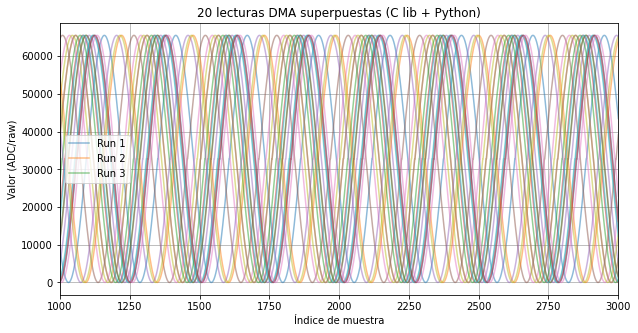

In [86]:
import time
import numpy as np
import matplotlib.pyplot as plt
import ctypes

num_runs = 20
dma_times = []
read_times = []
all_data = []

# Abrir el handle una sola vez
h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

for i in range(num_runs):
    # -------------------------
    # Medir tiempo DMA
    # -------------------------
    t0 = time.perf_counter()

    ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)

    t1 = time.perf_counter()
    dma_times.append((t1 - t0) * 1e3)

    if ret == 0:
        # -------------------------
        # Medir tiempo de lectura
        # -------------------------
        t0 = time.perf_counter()

        ptr = lib.dma_get_buffer_ptr(h)
        length_words = DST_MAP_SIZE // 4
        buffer_type = ctypes.c_uint32 * length_words
        buf = buffer_type.from_address(ptr)
        np_arr = np.ctypeslib.as_array(buf)

        t1 = time.perf_counter()
        read_times.append((t1 - t0) * 1e3)

        # Guardar copia en uint16 para graficar
        data = np.array(np_arr, dtype=np.uint16)
        all_data.append(data)

        print(f"Run {i+1:02d}: DMA = {dma_times[-1]:.3f} ms, Read = {read_times[-1]:.3f} ms")

    elif ret == 1:
        print(f"Run {i+1:02d}: DMA TIMEOUT")
    else:
        print(f"Run {i+1:02d}: DMA ERROR")

# -------------------------
# Estadísticas
# -------------------------
print("\n=== Benchmark summary (20 runs, C lib) ===")
print(f"DMA avg:   {np.mean(dma_times):.3f} ms (± {np.std(dma_times):.3f})")
print(f"Read avg:  {np.mean(read_times):.3f} ms (± {np.std(read_times):.3f})")

# -------------------------
# Graficar todas las curvas
# -------------------------
if all_data:
    plt.figure(figsize=(10,5))
    x = np.arange(len(all_data[0]))

    for i, d in enumerate(all_data):
        plt.plot(x, d, alpha=0.5, label=f"Run {i+1}" if i < 3 else None)

    plt.title("20 lecturas DMA superpuestas (C lib + Python)")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    plt.xlim([1000, 3000])
    plt.legend()
    plt.show()

lib.dma_close(h)